# Carotte 4.0 : Traitement d'images Hyperspectrales
Ce notebook Jupyter présentera les différentes expérimentations qui ont mené à la détermination de notre Pipeline de traitement d'images hyperspectrales.

In [1]:
# imports usuels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage
import sklearn
%matplotlib inline

# Données
Les deux images que nous possédons pour créer notre pipeline ont été acquises par le capteur AVIRIS.

## Afficher des images hyperspectrales en RGB

Les images ont été récupérées avec un capteur faisant du : 400 μm (visible/bleu) jusqu'à 2500 μm (proche infrarouge), avec une largeur de bande de 10 nm.

Wikipedia donne :
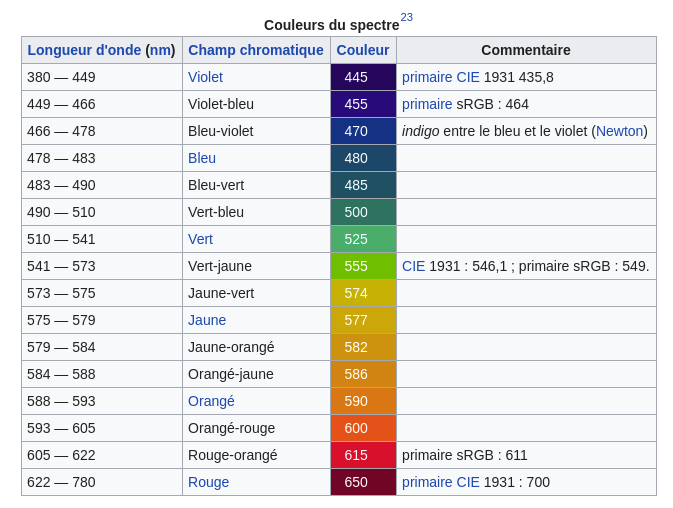

Il faut donc récupérer les longeurs d'ondes 464; 549 et 611 si l'on souhaite reconstruire l'image en RGB.

$$
\begin{align}
400 + 10 \times i &= \lambda\\
i &= \frac{\lambda - 400}{10}
\end{align}
$$

In [2]:
def find_index_wavelength(lambda_wl):
    return round((lambda_wl - 400) / 10)
def normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())
def rgb_bands(arr):
    r = find_index_wavelength(611)
    g = find_index_wavelength(549)
    b = find_index_wavelength(464)
    return [r, g, b]
def pimpImageInRgb(image, rgb_bands):
    img_rgb = image.copy()[:,:,rgb_bands]
    
    rgb_min, rgb_max = np.percentile(img_rgb, (1, 99), axis=(0,1))

    new_image = img_rgb.copy()
    for i in range(rgb_min.size):
        new_image[:,:,i] = (img_rgb[:,:,i] - rgb_min[i]) / (rgb_max[i] - rgb_min[i])
    
    new_image[new_image < 0] = 0
    new_image[new_image > 1] = 1
    return new_image

## Indiana Pines
C'est la première image que nous possédons. Elle à une résolution de 145x145 pixels, ce qui donne une résolution au sol de 20 m/pixel.
L'image de vérité terrain contient 15 classes différentes, avec la classe 0 appartenant à la catégorie "Inconnu".

In [3]:
# import de l'image indiana pines
arr_indiana = np.load("./data/indianapines.npy")
arr_indiana_gt = np.load("./data/indianapines_gt.npy")

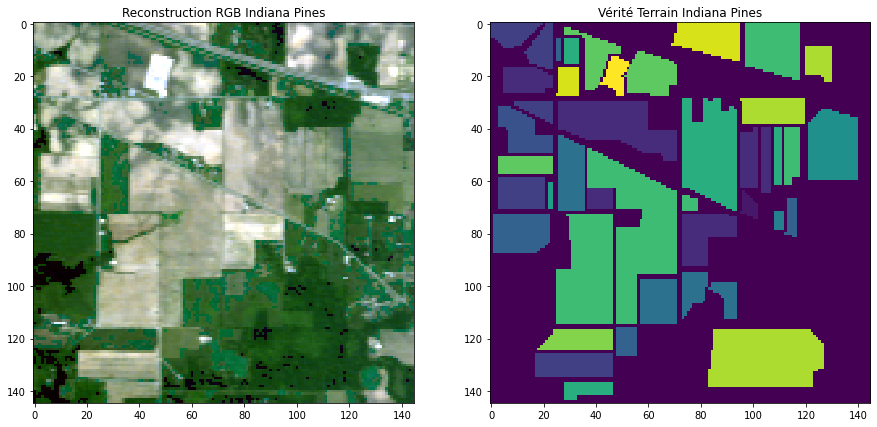

In [4]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[1].imshow(arr_indiana_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[1].set_title("Vérité Terrain Indiana Pines")
axs[0].imshow(pimpImageInRgb(normalize(arr_indiana), rgb_bands(arr_indiana)), cmap="viridis", aspect="auto", interpolation="none")
axs[0].set_title("Reconstruction RGB Indiana Pines")
plt.show()

In [5]:
indiana_dict = {
    "unknown" : 10776,
    "alfalfa" : 46,
    "corn-notill": 1428,
    "corn-mintill": 830,
    "corn": 237,
    "grass-pasture": 483,
    "grass-trees": 730,
    "grass-pasture-mowed": 28,
    "hay-windrowed": 478,
    "oats": 20,
    "soybean-notill": 972,
    "soybean-mintill": 2455,
    "soybean-clean": 593,
    "wheat": 205,
    "woods": 1265,
    "buildings-grass-trees-drives": 386,
    "stone-steel-towers": 93
}

On remarque le manque d'information pour certaines classes, notamment "oats" et "grass-pasture-mowed". Cela rendra la classification difficile pour ces classes en particulier.

## Salinas
Cette image possède des classes différentes de l'image Indiana Pines. Elle à aussi une résolution supérieure de 512x217 pixels.
Elle devrait ainsi être plus simple à traiter.

In [6]:
# import de la vérité terrain
arr_salinas = np.load("./data/salinas.npy")
arr_salinas_gt = np.load("./data/salinas_gt.npy")

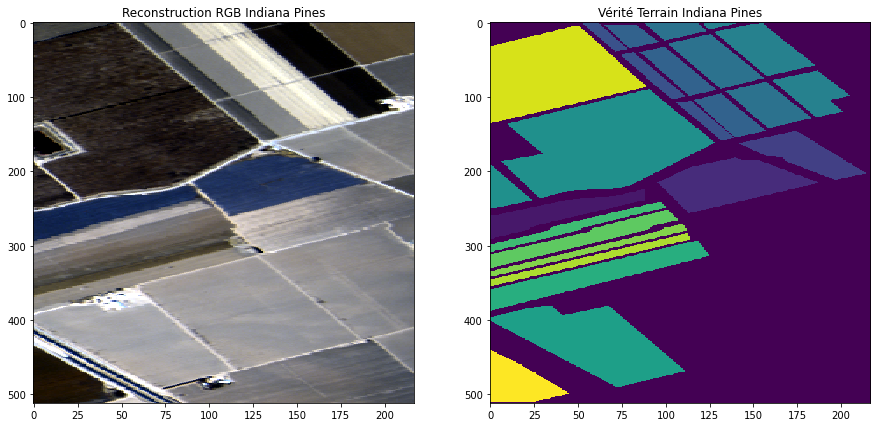

In [7]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[1].imshow(arr_salinas_gt, cmap="viridis", aspect="auto", interpolation="none")
axs[1].set_title("Vérité Terrain Indiana Pines")
axs[0].imshow(pimpImageInRgb(normalize(arr_salinas), rgb_bands(arr_salinas)), cmap="viridis", aspect="auto", interpolation="none")
axs[0].set_title("Reconstruction RGB Indiana Pines")
plt.show()

In [8]:
salinas_dict = {
    "unknown" : 56975,
    "brocoli_green_weeds_1" : 2009,
    "brocoli_green_weeds_2" : 3726,
    "fallow" : 1976,
    "fallow_rough_plow" : 1394,
    "fallow_smooth" : 2678,
    "stubble" : 3959,
    "celery" : 3579,
    "grapes_untrained" : 11271,
    "soil_vinyard_develop" : 6203,
    "corn_senesced_green_weeds" : 3278,
    "lettuce_romaine_4wk" : 1068,
    "lettuce_romaine_5wk" : 1927,
    "lettuce_romaine_6wk" : 916,
    "lettuce_romaine_7wk" : 1070,
    "vinyard_untrained" : 7268,
    "vinyard_vertical_trellis" : 1807
}

**Essayer de retirer totalement la classe unknown du dataset de train ?**

# Réduction de dimension
Les images hyperspectrales possédant un nombre très important de bandes pour chaque pixel, elle pourront fortement bénificier d'une réduction, permettant de traiter ces images plus rapidement, et de se focaliser sur les caractéristiques essentielles.

## Analyse en composantes principales
La technique d'analyse en composantes principales (ou PCA) permet d'effectuer une réduction de dimension, en ne gardant que les premières composantes.
Appliquons cette méthode à nos images, et observons la perte de données associée.

In [9]:
from math import ceil
def show_info_pca(arr, varFactor):
    row, col, dim = arr.shape
    # The array is reshaped to be flat
    arr_flat = arr.reshape((-1, dim))
    
    import sklearn.decomposition
    pca_arr = sklearn.decomposition.PCA()
    pca_arr.fit(arr_flat)
    
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.title('Explained variance per PC')
    plt.plot(np.arange(1,dim+1),pca_arr.explained_variance_,'b')
    plt.xlabel('PC number')
    plt.xlim(1,dim+1)
    plt.subplot(122)
    plt.title('Explained variance per PC (in log scale)')
    plt.plot(np.arange(1,dim+1),pca_arr.explained_variance_,'b')
    plt.xlabel('PC number')
    plt.xlim(1,dim+1)
    plt.yscale('log')
    plt.show()
    
    
    
    var_cumsum = pca_arr.explained_variance_ratio_.cumsum()
    
    nbPCs = np.where(var_cumsum > varFactor)[0][0]
    print('%d components are necessary to retain %1.2f%% of the total variance'%((nbPCs+1),100*varFactor))
    
    nb_comp = nbPCs
    
    arr_projected = pca_arr.transform(arr_flat)
    arr_projected_small = arr_projected[:,:nb_comp].reshape((row,col,nb_comp))
    
    plt.figure(figsize=(30,12))
    nb_shown = 10 if nb_comp >= 10 else nb_comp
    for i in range(nb_shown):
        plt.subplot(2,5,i+1)
        plt.title('PC %d'%(i+1),fontsize=18)
        plt.imshow(arr_projected_small[:,:,i],cmap='gray', aspect="auto")
    print("Here are the first", nb_shown,"components.")
    plt.show()
    
    arr_projected_full = arr_projected.copy()
    arr_projected_full[:,nbPCs:] = 0
    arr_proj_back = pca_arr.inverse_transform(arr_projected_full).reshape((row,col,dim))
    
    plt.figure(figsize=(20,9))
    plt.subplot(121)
    plt.imshow(pimpImageInRgb(normalize(arr), rgb_bands(arr)), aspect="auto")
    plt.title("Original Image in RGB")
    plt.subplot(122)
    plt.imshow(pimpImageInRgb(normalize(arr_proj_back), rgb_bands(arr_proj_back)), aspect="auto")
    plt.title("Reconstructed Image from kept components")
    plt.show()

## Indiana Pines

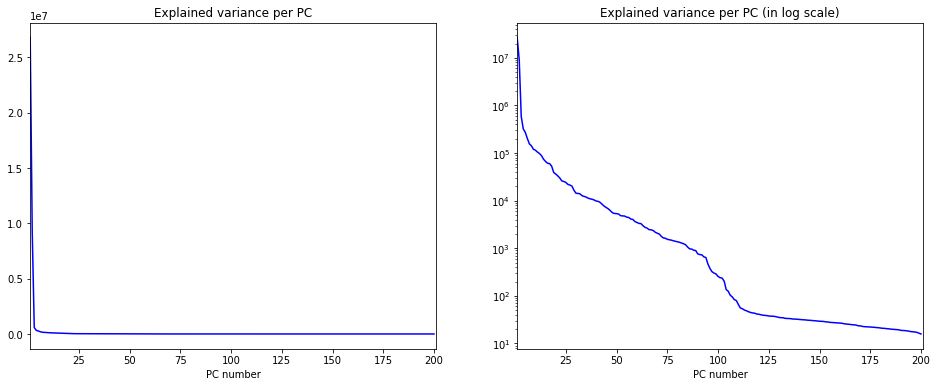

25 components are necessary to retain 99.00% of the total variance
Here are the first 10 components.


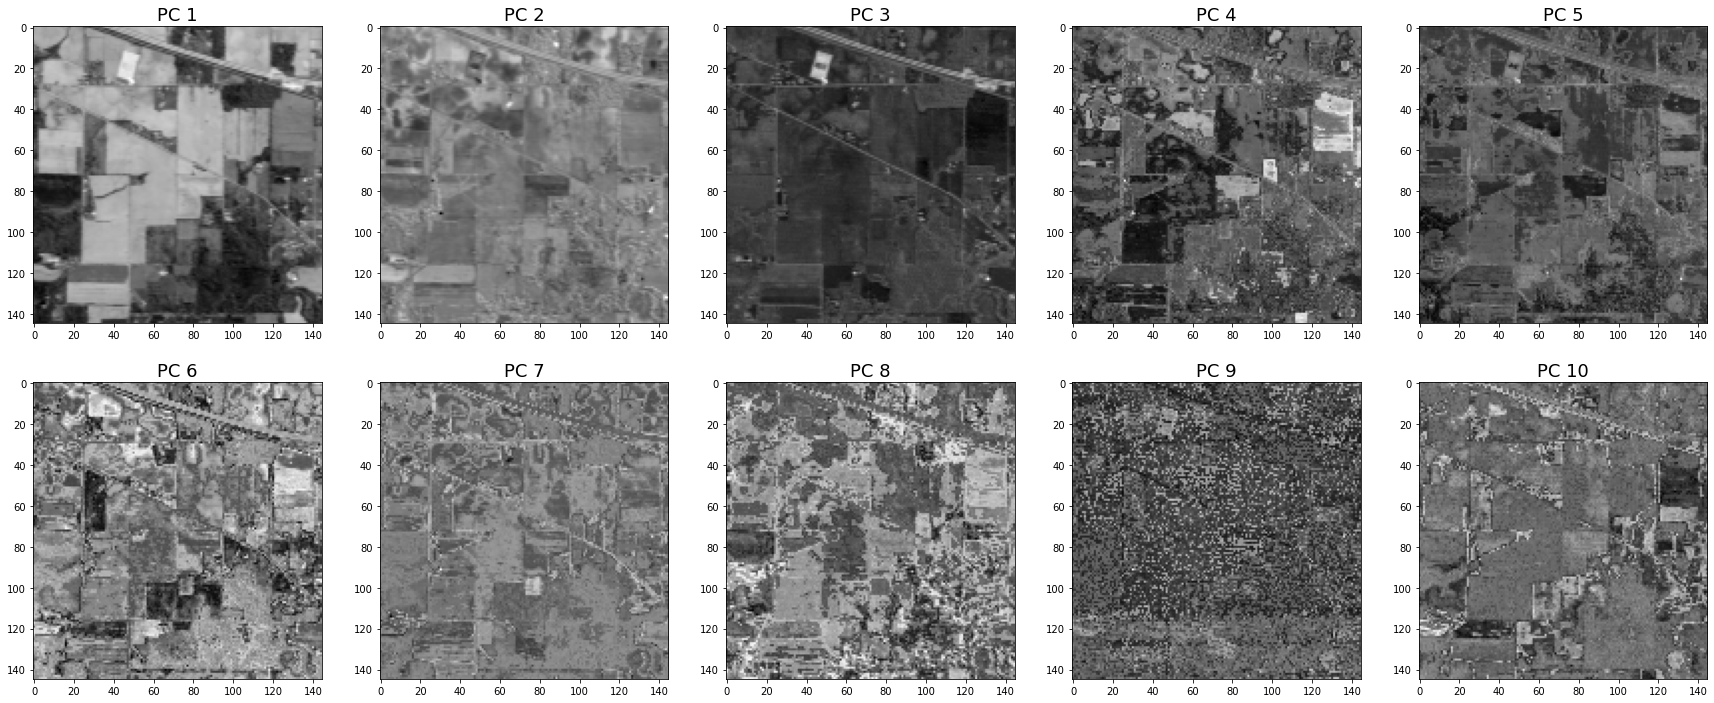

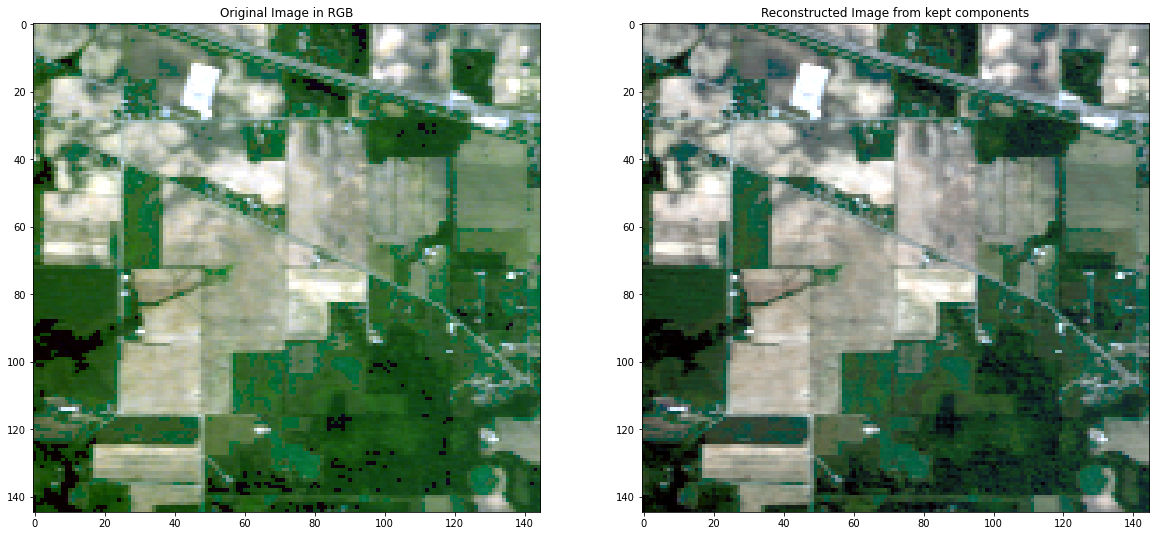

In [10]:
show_info_pca(arr_indiana, 0.99)

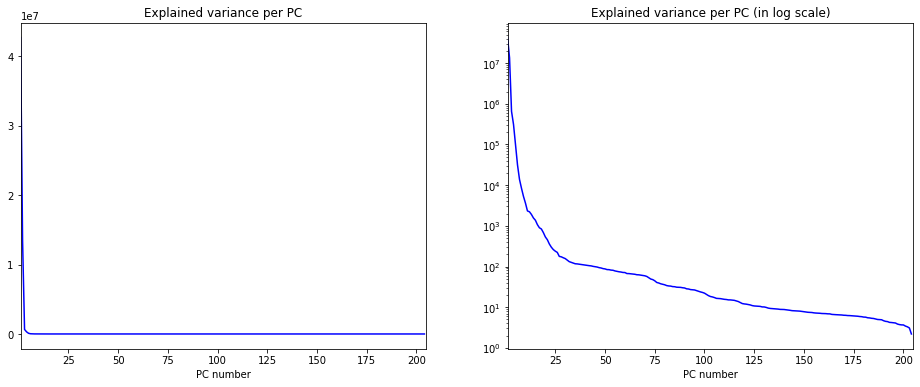

6 components are necessary to retain 99.90% of the total variance
Here are the first 5 components.


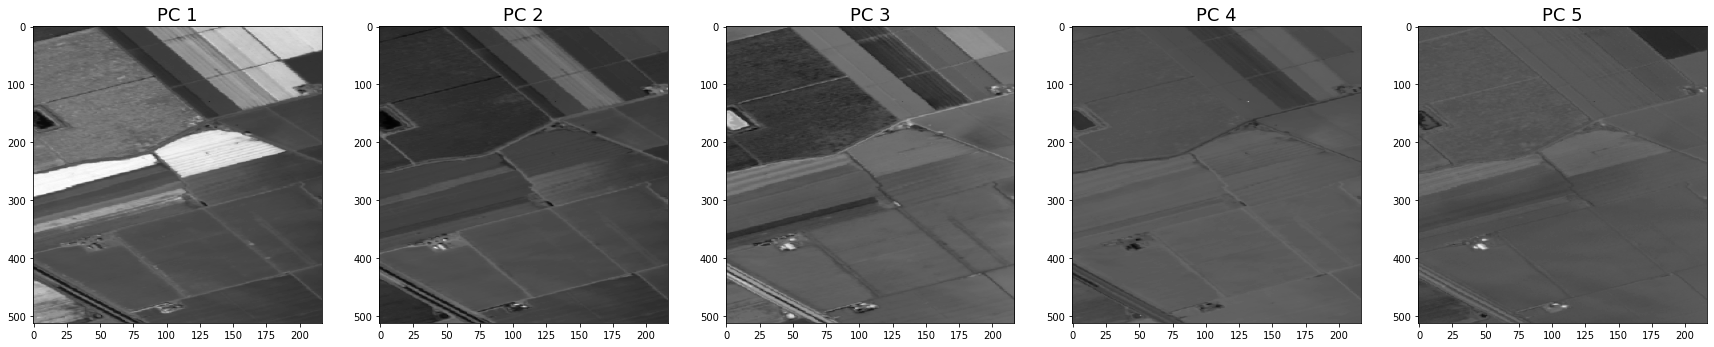

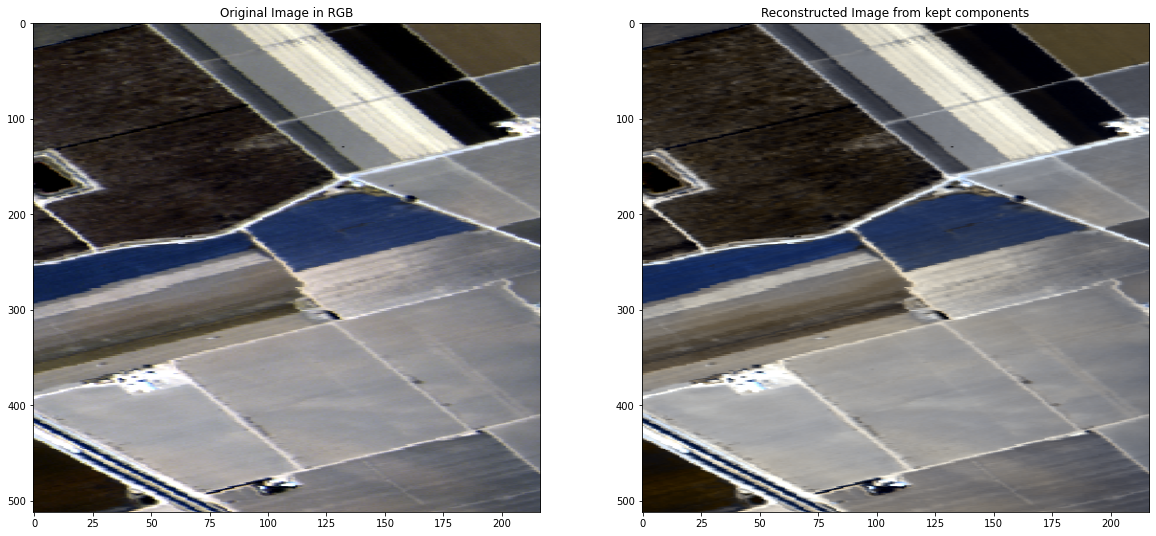

In [11]:
show_info_pca(arr_salinas, 0.999)

- On remarque que l'image Indiana pines demande de garder beaucoup plus de composantes pour avoir une variance de 99%, comparé à l'image Salinas qui atteind une variance expliquée de 99.9% avec seulement 5 composantes.\
Nous voyons donc bien qu'il sera critique que notre pipeline de traitement d'image puisse s'adapter à l'image d'entrée. Cela peut se traduire par l'ajout d'hyperparamètres qui seraient réglés pour chaque image d'entrée.
- Un autre point critique ici est le fait que nous avons effectué notre PCA sur l'entiereté du set de données. Seulement, en pratique nous auront seulement accès à une partie de l'image, le set d'entrainement.\
Il faudra donc que la décomposition apprise sur le set d'entrainement convient aussi au set de test. La partie suivante traite justement de la séparation en deux sets.


# Séparation en Train et Test set et approche de classification

Les deux images possédant des classes et une résolution différentes, apprendre les données d'une image pour ensuite classifier celles de l'autre n'a pas de sens.

Il va plutot convenir ici d'apprendre à classifier une partie de chaque image, qui sera le set d'entrainement, pour ensuite évaluer l'efficacité de la méthode sur le reste de l'image.

Cette approche à un avantage non négligeable : Travailler avec un dataset de train réduit, composé environ de 15% des pixels de l'image d'origine permettra lors de la classification de seulement labelliser 15% des images acquises, la pipeline de classification de chargeant d'induire le reste des labels.

Cela expose aussi l'approche *pixel-wise* que nous allons avoir. Chaque pixel sera en effet traité indépendemment de sa position sur l'image, en utilisant seulement les informations des bandes. Cela permet de créer des Test et Train set ayant la même répartition de classes, sans de voir découper des zones contigues dans l'image.

In [12]:
from sklearn.model_selection import train_test_split

def create_test_train(arr, arr_gt, test_size):
    arr = np.copy(arr)
    arr_gt = np.copy(arr_gt)
    
    # Encode in the last two band of each pixel the position of the pixel.
    # This is used for reforming the image from the test and train set a posteriori
    indices = []
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            indices.append([i, j])
    indices = np.array(indices)
    
    dim = arr.shape[2]
    # flatten X and y
    X = arr.reshape((-1, dim))
    y = arr_gt.reshape((-1))
    # add the pixel positions into X
    X = np.column_stack([X, indices])
    
    # do the splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # retrieve the indices for each pixel
    
    train_indices = X_train[:,-2:]
    test_indices = X_test[:, -2:]
    
    # remove the indices from X_train and X_test
    
    X_train = X_train[:,:-2]
    X_test = X_test[:, :-2]
    
    return X_train, X_test, y_train, y_test, train_indices, test_indices

def rebuild_image(y_train, y_predicted, train_indices, test_indices, height, width):
    y_rebuilt = np.zeros((height, width))
    
    # set all the pixels predicted to their predicted value
    for i in range(len(y_predicted)):
        h, w = test_indices[i]
        y_rebuilt[h, w] = y_predicted[i]
    # set all the train pixels to their value
    for i in range(len(y_train)):
        h, w = train_indices[i]
        y_rebuilt[h, w] = y_train[i]
        
    return y_rebuilt

Par exemple, en mettant toutes les valeurs prédites à 0 :

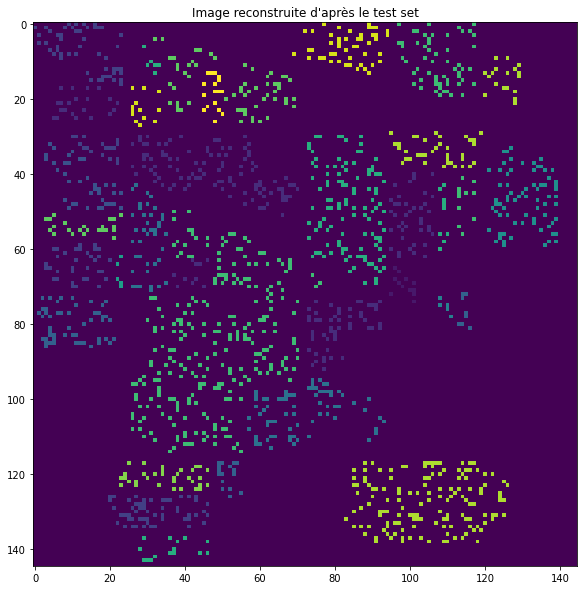

In [13]:
(X_train,
X_test,
y_train,
y_test,
train_indices,
test_indices) = create_test_train(arr_indiana, arr_indiana_gt, 0.85)

plt.figure(figsize=(10,10))
plt.imshow(rebuild_image(y_train, np.ones_like(y_test) * 0,
                         train_indices, test_indices,
                         arr_indiana.shape[0], arr_indiana.shape[1]))
plt.title("Image reconstruite d'après le test set")
plt.show()

Cette reconstruction sera aussi utile pour appliquer un post traitement.

# Premières approches de classification
Dans cette partie nous allons explorer la classification des pixels à l'aide de différents classifiers de scikit-learn.
Les tests seront ici effectués sur l'image indiana pines.

En effet, étant l'image avec le moins de donnée disponible, un classifier qui fonctionne bien sur cette image fonctionnera normalement bien sur une image plus détaillée.

La matrice de confusion, affichant la classe attribuée aux pixels en fonction de leur véritable classe sera utilisée pour rapidement identifier l'efficacité du classifier.\
Nous allons aussi nous intéresser aux métriques de précision, rappel ainsi que f-score pour chaque classifier.

Ces metriques permettent de quantifier à quel point le classifier attribue à chaque pixel la bonne classe, sans trop récompenser le fait d'attribuer la même classe à tous les pixels (précision).\
Le f-score fait intervenir les deux métriques, et permet donc de s'assurer qu'aucune des deux n'est trop faible.

Sera pris en compte aussi la durée pour fit le classifier en utilisant les données de train, ainsi que le temps pris pour prédire les labels.

In [354]:
def report_only_weighted(y_predicted, y_test):
    return pd.DataFrame(pd.DataFrame(classification_report(y_predicted, y_test, 
                                                zero_division=True, output_dict=True))["weighted avg"][:3])

In [355]:
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from IPython.display import display, HTML
from time import time

pd.set_option('display.float_format','{:.2f}'.format)

def showMetricsClassifier(X, y, clf):
    (X_train,
    X_test,
    y_train,
    y_test,
    train_indices,
    test_indices) = create_test_train(X, y, 0.85)
    
    # Setup Pipeline for explained variance of 0.99
    
    _, counts = np.unique(X_train, return_counts=True)
    class_weights = {i + 1 : counts[i] for i in range(len(counts))}
    
    pipe = Pipeline(steps=[('pca', sklearn.decomposition.PCA(n_components=0.99)),
                       ('clf', clf)])
    
    duration = time()
    pipe.fit(X_train, y_train)
    duration = time() - duration
    # Test and show metrics
    
    fig, ax = plt.subplots(figsize=(12,12))
    plot_confusion_matrix(pipe, X_test, y_test, ax=ax, display_labels=indiana_dict,
                          xticks_rotation="vertical",normalize="true",
                         colorbar=False, cmap="Blues")
    predict_duration = time()
    y_predicted = pipe.predict(X_test)
    predict_duration = time() - predict_duration
    plt.show()
    
    print("Image comparison")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    ax2.imshow(y, aspect="auto")
    ax2.set_title("Ground Truth")
    ax1.imshow(rebuild_image(y_train, y_predicted,
                         train_indices, test_indices,
                         X.shape[0], y.shape[1]), aspect="auto")
    ax1.set_title("Reconstructed image from predictions")
    plt.show()
    
    df = report_only_weighted(y_predicted, y_test)
    new_row = pd.Series(data={'weighted avg':duration}, name='fit_duration')
    df = df.append(new_row)
    new_row = pd.Series(data={'weighted avg':predict_duration}, name='predict_duration')
    df = df.append(new_row)
    display(df)
    return df

In [356]:
X = arr_indiana
y = arr_indiana_gt

In [357]:
results_df = pd.DataFrame()

## `DecisionTreeClassifier`

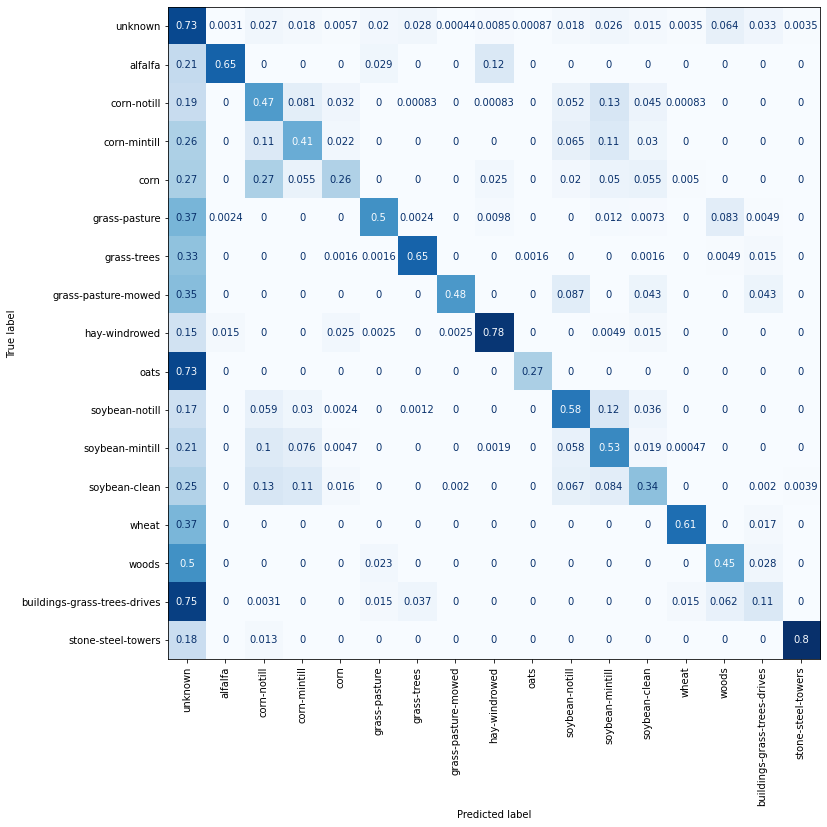

Image comparison


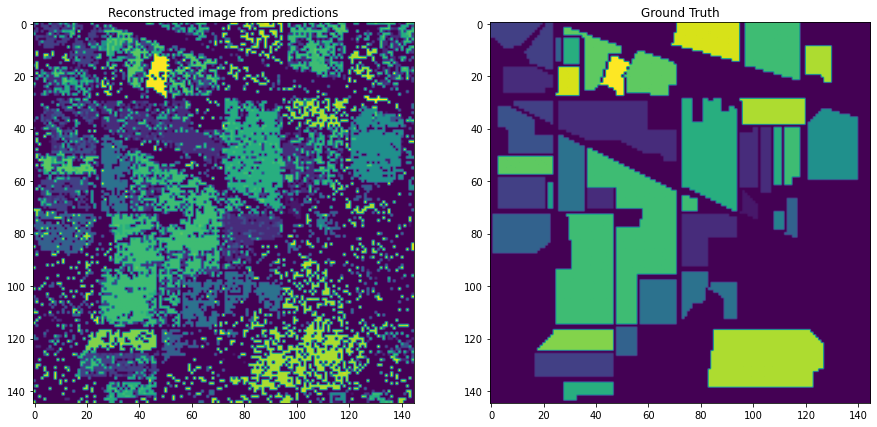

weighted avg
precision                 0.61
recall                    0.61
f1-score                  0.61
fit_duration              0.14
predict_duration          0.03

CPU times: user 2.16 s, sys: 2 s, total: 4.16 s
Wall time: 1.43 s


In [358]:
%%time
from sklearn.tree import DecisionTreeClassifier

df = showMetricsClassifier(X, y, DecisionTreeClassifier(class_weight="balanced", random_state=42))
df = df.rename(columns={"weighted avg": "DecisionTreeClassifier"})
results_df = pd.concat([results_df, df], axis=1)

## `RandomForestClassifier`

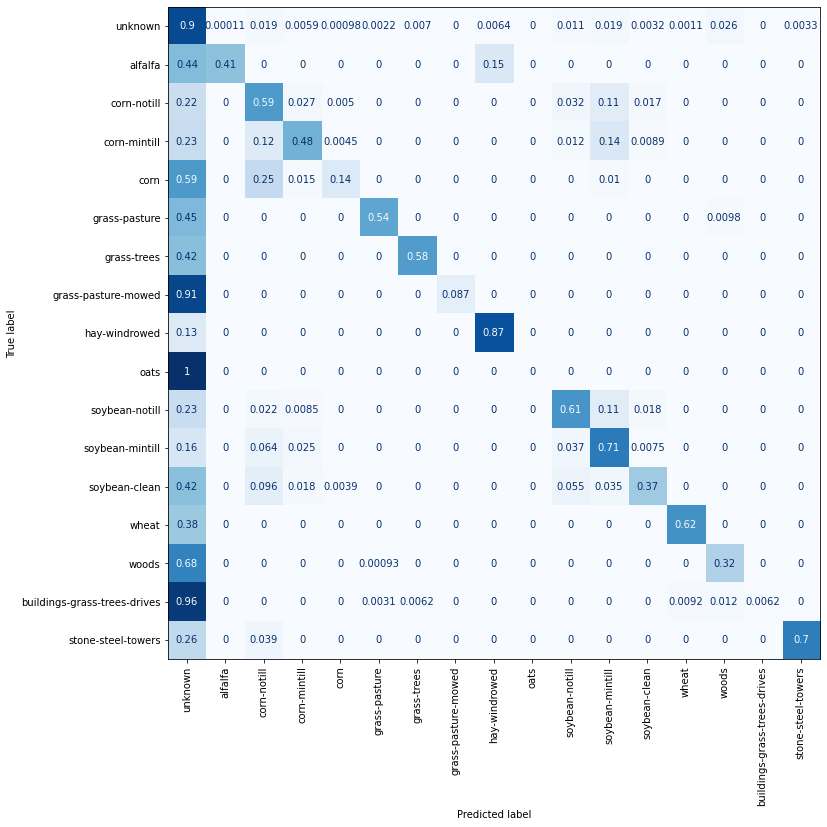

Image comparison


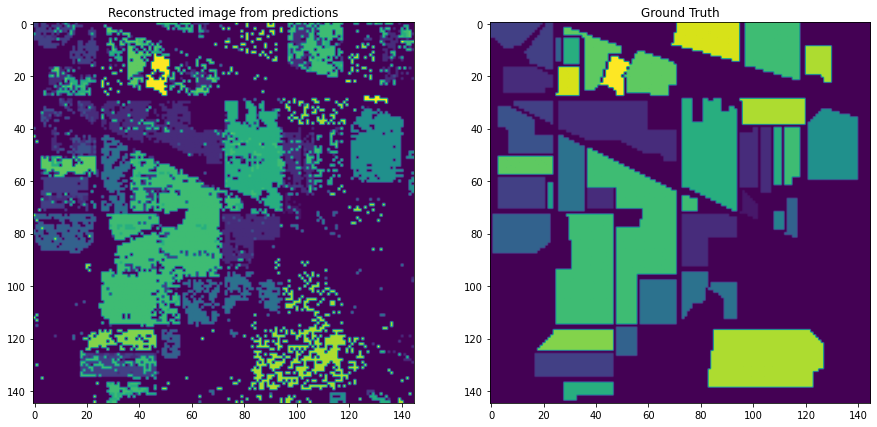

weighted avg
precision                 0.78
recall                    0.72
f1-score                  0.74
fit_duration              1.32
predict_duration          0.31

CPU times: user 4.45 s, sys: 2.21 s, total: 6.66 s
Wall time: 3.55 s


In [155]:
%%time
from sklearn.ensemble import RandomForestClassifier

df = showMetricsClassifier(X, y, RandomForestClassifier(class_weight="balanced", random_state=42))
df = df.rename(columns={"weighted avg": "RandomForestClassifier"})
results_df = pd.concat([results_df, df], axis=1)

## `ExtraTreesClassifier`

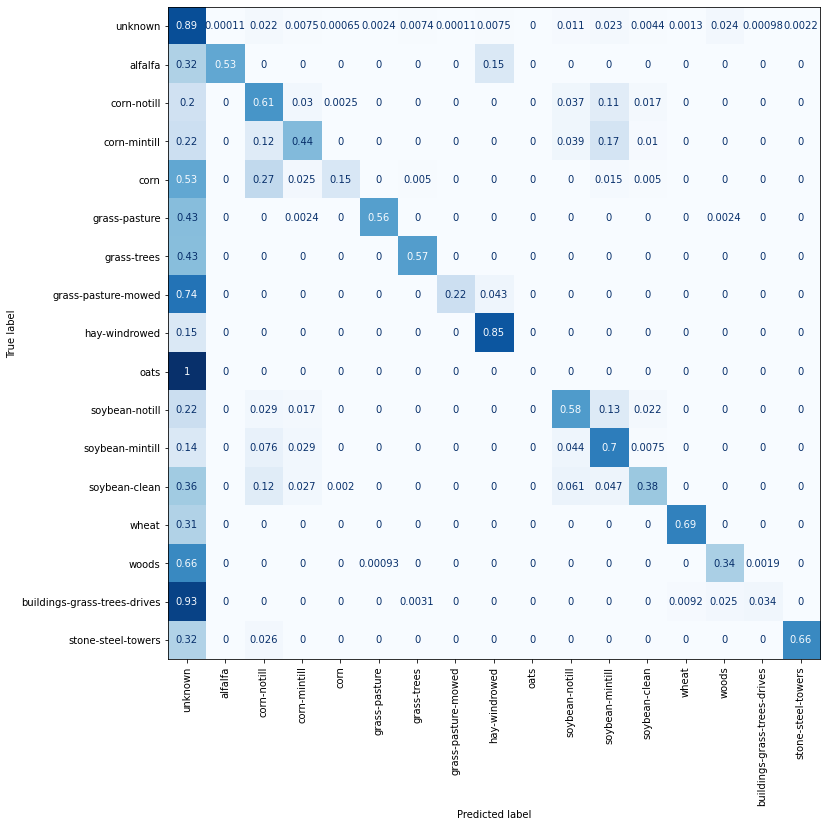

Image comparison


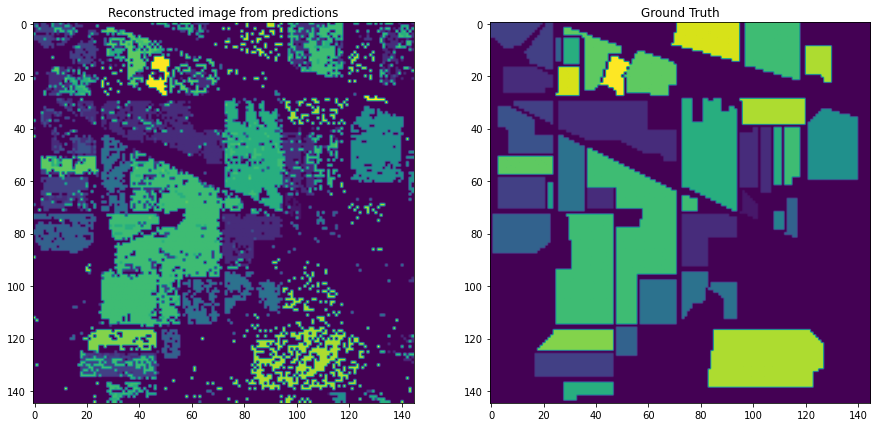

weighted avg
precision                 0.77
recall                    0.72
f1-score                  0.74
fit_duration              0.44
predict_duration          0.35

CPU times: user 3.08 s, sys: 2.22 s, total: 5.3 s
Wall time: 2.32 s


In [156]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

df = showMetricsClassifier(X, y, ExtraTreesClassifier(class_weight="balanced", random_state=42))
df = df.rename(columns={"weighted avg": "ExtraTreesClassifier"})
results_df = pd.concat([results_df, df], axis=1)

## `SVC` (rbf)

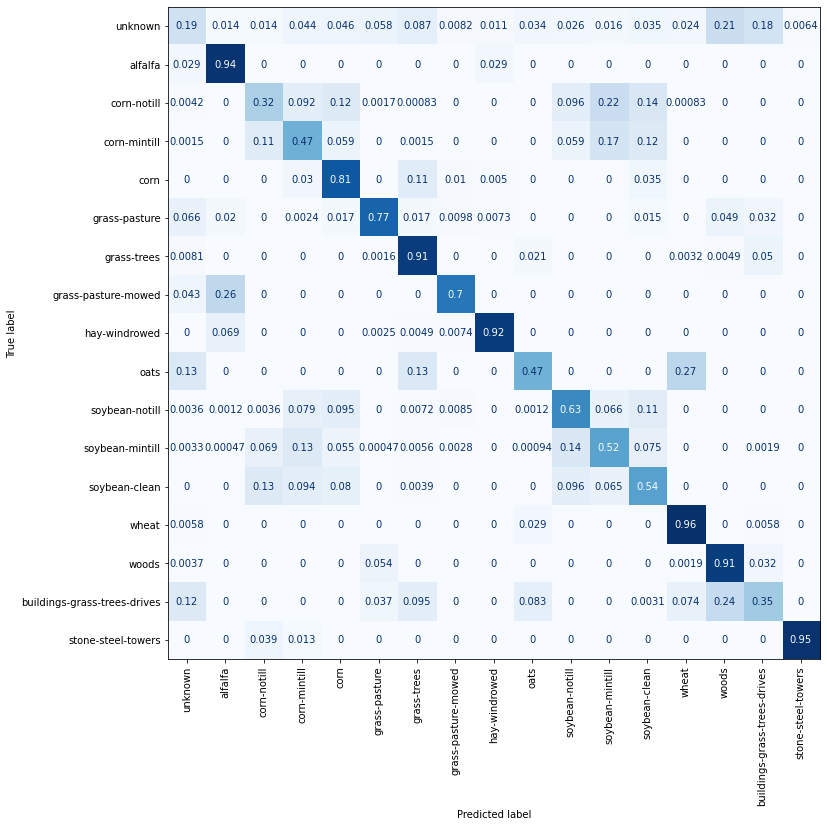

Image comparison


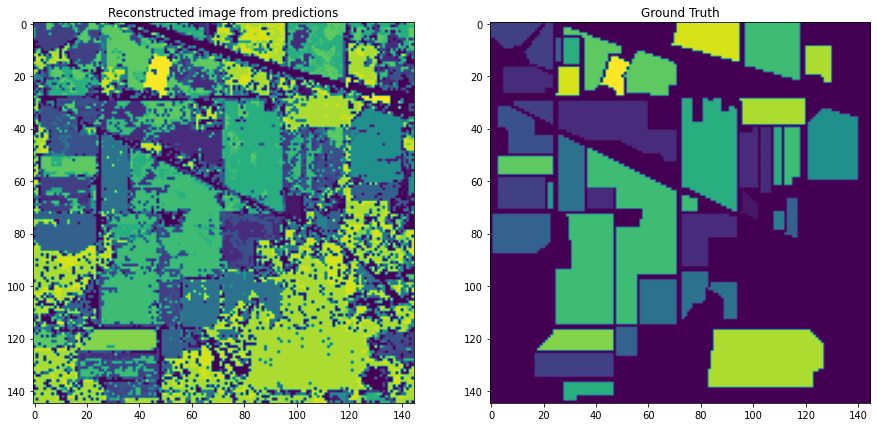

weighted avg
precision                 0.62
recall                    0.40
f1-score                  0.40
fit_duration              0.52
predict_duration          2.70

CPU times: user 7.99 s, sys: 2.19 s, total: 10.2 s
Wall time: 7.09 s


In [157]:
%%time
from sklearn.svm import SVC

df = showMetricsClassifier(X, y, SVC(kernel="rbf", class_weight="balanced", random_state=42))
df = df.rename(columns={"weighted avg": "SVC(rbf)"})
results_df = pd.concat([results_df, df], axis=1)

## `LinearSVC`

/home/alexandre/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


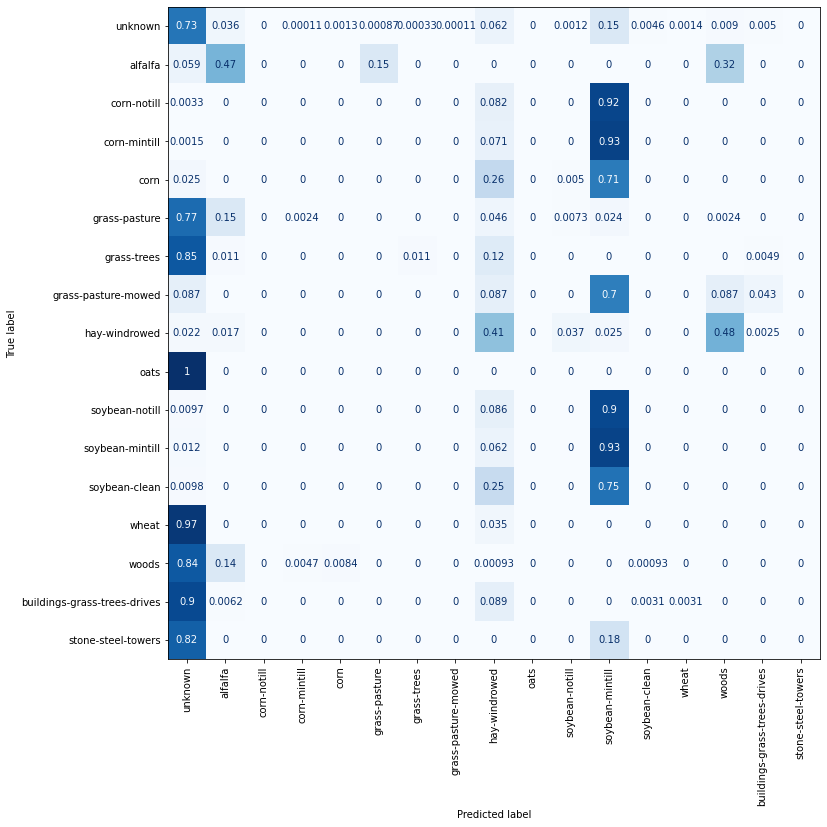

Image comparison


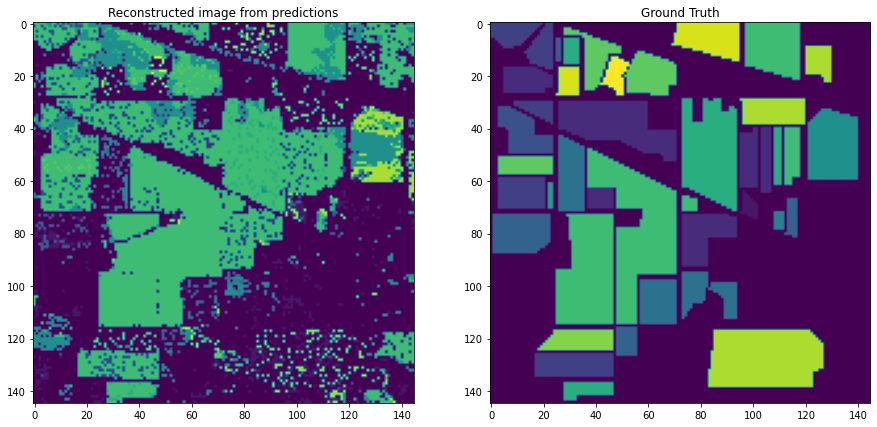

weighted avg
precision                 0.75
recall                    0.50
f1-score                  0.56
fit_duration             31.81
predict_duration          0.03

CPU times: user 33.4 s, sys: 2.03 s, total: 35.5 s
Wall time: 33 s


In [158]:
%%time
from sklearn.svm import LinearSVC

df = showMetricsClassifier(X, y, LinearSVC(class_weight="balanced", max_iter=10000, random_state=42))
df = df.rename(columns={"weighted avg": "LinearSVC"})
results_df = pd.concat([results_df, df], axis=1)

## `KNeighborsClassifier`

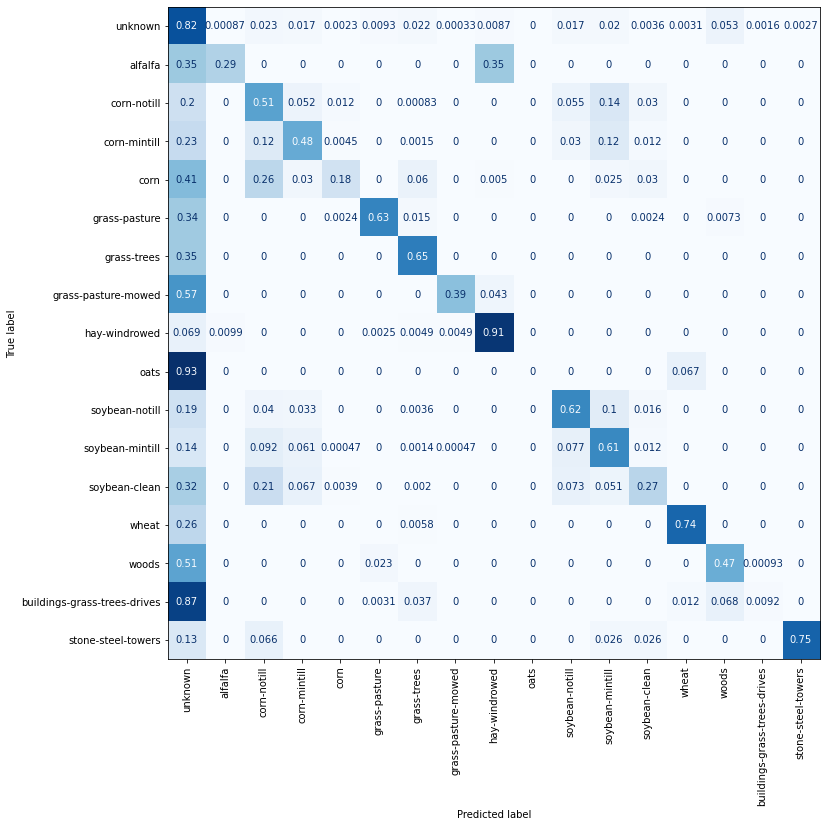

Image comparison


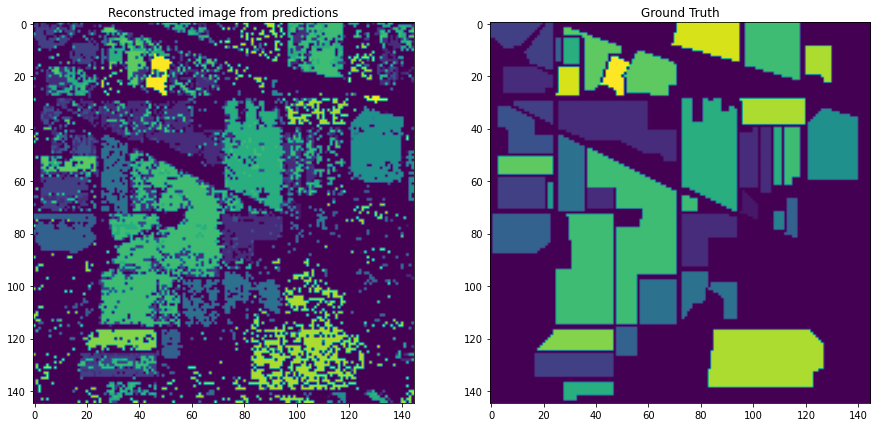

weighted avg
precision                 0.71
recall                    0.68
f1-score                  0.69
fit_duration              0.05
predict_duration          1.32

CPU times: user 5.2 s, sys: 4.69 s, total: 9.88 s
Wall time: 4.03 s


In [159]:
%%time
from sklearn.neighbors import KNeighborsClassifier

df = showMetricsClassifier(X, y, KNeighborsClassifier())
df = df.rename(columns={"weighted avg": "KNeighborsClassifier"})
results_df = pd.concat([results_df, df], axis=1)

In [160]:
results_df

DecisionTreeClassifier  RandomForestClassifier  \
precision                           0.61                    0.78   
recall                              0.61                    0.72   
f1-score                            0.61                    0.74   
fit_duration                        0.14                    1.32   
predict_duration                    0.03                    0.31   

                  ExtraTreesClassifier  SVC(rbf)  LinearSVC  \
precision                         0.77      0.62       0.75   
recall                            0.72      0.40       0.50   
f1-score                          0.74      0.40       0.56   
fit_duration                      0.44      0.52      31.81   
predict_duration                  0.35      2.70       0.03   

                  KNeighborsClassifier  
precision                         0.71  
recall                            0.68  
f1-score                          0.69  
fit_duration                      0.05  
predict_duration                  1.32

Que tirer de ces essais ? Nous remarquons plusieurs choses.

- Les classifiers `KNeighborsClassifier` et `RandomForestClassifier` sont ceux  qui on l'air d'avoir les meilleurs résultats avec leurs paramètres de base. Nous pourront donc nous interesser à ces dernier et ajuster leurs paramètres afin d'augmenter encore le score.
- Sur l'image utilisée pour effectuer cette comparaison, la faible quantité de la classe "oats" empèche une classification efficace de cette dernière
- Les classifiers ont en général des difficultés à distinguer les différents types de mais et de soja les uns des autres
- Le fait que la classe "inconnu" soit la plus présente amène un grand nombre de classifiers à préférer cette dernière

# Utiliser GridSearch pour obtenir le meilleur classifier

Jusqu'à maintenant, mous avons seulement utilisé les classifiers avec leurs paramètres de base.
Nous allons maintenant essayer de trouver les paramètres optimaux pour déterminer lequel utiliser.

Ces paramètres seront optimaux pour les données considérées, mais pas forcément pour le problème en lui même.

In [161]:
from sklearn.model_selection import GridSearchCV

## `RandomForestClassifier`

Commençons par le `RandomForestClassifier`.

In [214]:
clf = RandomForestClassifier(random_state=42)
(X_train,
X_test,
y_train,
y_test,
train_indices,
test_indices) = create_test_train(X, y, 0.85)

gs = GridSearchCV(clf, {
                       'criterion':["gini", "entropy"],
                       'max_features': ["auto", "sqrt", "log2"],
                       'bootstrap': [True, False],
                       'random_state': [42]
                       }, refit=True)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'random_state': [42]})

In [218]:
# pd.DataFrame(gs.cv_results_)
print(gs.best_params_)
clf = gs.best_estimator_

{'bootstrap': False, 'criterion': 'entropy', 'max_features': 'auto', 'random_state': 42}


In [216]:
y_predict = clf.predict(X_test)

In [217]:
print(classification_report(y_pred=y_predict, y_true=y_test))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      9180
           1       0.96      0.74      0.83        34
           2       0.68      0.71      0.69      1202
           3       0.71      0.67      0.69       674
           4       0.56      0.24      0.34       200
           5       0.89      0.66      0.76       409
           6       0.87      0.63      0.73       617
           7       0.83      0.43      0.57        23
           8       0.87      0.90      0.88       406
           9       0.50      0.07      0.12        15
          10       0.69      0.73      0.71       828
          11       0.77      0.79      0.78      2130
          12       0.69      0.50      0.58       510
          13       0.88      0.83      0.85       172
          14       0.64      0.49      0.55      1071
          15       0.75      0.01      0.02       325
          16       0.70      0.67      0.68        76

    accuracy              

Le meilleur classifier choisi ici semble apporter des améliorations par rapport aux paramètres de base, avec un gain de 0.02 points sur la métrique de f-score. 

## `KNeighborsClassifier`

In [220]:
clf = KNeighborsClassifier()
(X_train,
X_test,
y_train,
y_test,
train_indices,
test_indices) = create_test_train(X, y, 0.85)

gs = GridSearchCV(clf, {
                       'n_neighbors': np.arange(3, 7),
                       'algorithm': ["auto", "ball_tree", "kd_tree", "brute"],
                       'leaf_size': np.arange(20, 40, 5),
                       'p':[1, 2]
                       }, refit=True)
gs.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': array([20, 25, 30, 35]),
                         'n_neighbors': array([3, 4, 5, 6]), 'p': [1, 2]})

In [221]:
# pd.DataFrame(gs.cv_results_)
print(gs.best_params_)
clf = gs.best_estimator_
y_predict = clf.predict(X_test)
print(classification_report(y_pred=y_predict, y_true=y_test))

{'algorithm': 'auto', 'leaf_size': 20, 'n_neighbors': 4, 'p': 1}
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      9180
           1       0.63      0.50      0.56        34
           2       0.57      0.59      0.58      1202
           3       0.55      0.58      0.56       674
           4       0.47      0.16      0.24       200
           5       0.78      0.67      0.72       409
           6       0.69      0.65      0.67       617
           7       0.72      0.57      0.63        23
           8       0.82      0.89      0.85       406
           9       0.50      0.07      0.12        15
          10       0.61      0.72      0.66       828
          11       0.75      0.67      0.71      2130
          12       0.57      0.35      0.43       510
          13       0.78      0.85      0.82       172
          14       0.55      0.42      0.48      1071
          15       0.18      0.02      0.03       325
          16    

Ici le gain sur le f-score semble être de 0.02 points aussi.

L'optimisation d'hyper paramètres permet donc d'améliorer la précision de nos classifiers.
Le `RandomForestClassifier` reste quand même le plus efficace. Ce sera donc celui choisi pour notre pipeline.

# Utiliser l'information spatiale
Pour le moment, nous nous somme uniquement attardés à faire de la classification par pixel, c'est à dire que les pixels sont classifiés indépendemment de leur position spatiale dans l'image.\
Seulement, au vu du problème abordé, il semble logique que des pixels voisins appartiennent à la même parcelle de champ.\
Nous pouvons ainsi nous demander s'il serait judicieux d'effectuer une segmentation des champs dans l'image, pour ensuite affecter aux pixels de la zone segmentée la classe majoritaire de la zone.

La fonction ci dessous va s'occuper d'intégrer l'information spatiale dans les prédictions à l'aide d'une image de labels fournie.
A chaque zone de l'image de labels sera attribuée la classe majoritaire de la zone.

In [370]:
def randomForestWithSpatialInfo(X, y, label_img):
    (X_train,
    X_test,
    y_train,
    y_test,
    train_indices,
    test_indices) = create_test_train(X, y, 0.85)
    
    # Setup Pipeline for explained variance of 0.99
    
    _, counts = np.unique(X_train, return_counts=True)
    class_weights = {i + 1 : counts[i] for i in range(len(counts))}
    
    clf = RandomForestClassifier(bootstrap=False,
                                 criterion='entropy',
                                 max_features= 'auto',
                                 random_state=42)
    
    pipe = Pipeline(steps=[('pca', sklearn.decomposition.PCA(n_components=0.99)),
                       ('clf', clf)])
    pipe.fit(X_train, y_train)
    
    y_predicted = pipe.predict(X_test)
    
    report = report_only_weighted(y_predicted, y_test)
    report = report.rename(columns={"weighted avg": "Before"})
    
    y_rebuilt = rebuild_image(y_train, y_predicted,
                         train_indices, test_indices,
                         X.shape[0], y.shape[1])
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].imshow(y_rebuilt)
    ax[0].set_title("Before Spatial information added")

    
    # use spatial info
    patches = len(np.unique(label_img))
    for patch in range(patches):
        ids, counts = np.unique(y_rebuilt[(label_img == patch)], return_counts=True)
        if (len(counts) != 0):
            y_rebuilt[(label_img == patch)] = ids[np.argmax(counts)]
    ax[1].imshow(y_rebuilt)
    ax[1].set_title("After Spatial information added")
    
    plt.show()
    
    # update y_predicted
    i = 0
    for h, w in test_indices:
        y_predicted[i] = y_rebuilt[h, w]
        i += 1
    # print metrics
    report = pd.concat([report,report_only_weighted(y_predicted, y_test)], axis=1)
    report = report.rename(columns={"weighted avg": "After"})
    display(report)

In [371]:
from matplotlib import cm

def show_image_seg(img, recolored, n_clusters):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Reference image")
    plt.subplot(1,2,2)
    plt.imshow(recolored.reshape(img.shape))
    plt.title(f"Segmented areas, {n_clusters} clusters")
    plt.show()
    
def random_lut(n_values):
    '''Build a random LUT for `n_values` elements (sequential integers).'''
    samples = np.linspace(0, 1, n_values)
    rng = np.random.default_rng(3)
    samples = rng.permutation(samples)
    colors = cm.hsv(samples, alpha=None, bytes=True)
    return colors[...,:3]

def addCoordiangeImage(src_image, /, normalization_factor=255.0):
    image = src_image.copy() / normalization_factor
    nx, ny = image.shape[0], image.shape[1]
    x = np.linspace(0, 1, nx)
    y = np.linspace(0, 1, ny)
    x = x / nx
    y = y / ny
    
    xv, yv = np.meshgrid(x,y)
    image = np.insert(image, 0, xv, axis=-1)
    image = np.insert(image, 0, yv, axis=-1)
    return image

def prepareImage(image, /, add_coords=False):
    if add_coords:
        image = addCoordiangeImage(image)
    return image

def applySimpleClusterer(image, image_ref, n_clusters, clusterer):
    n_features = image.shape[-1]
    lut = random_lut(n_clusters)
    
    print(f"n_features: {n_features}")
    labels = clusterer.fit_predict(image.reshape((-1,n_features)))
    show_image_seg(image_ref, lut[labels], n_clusters)
    return labels.reshape(image.shape[:2])
    
arr_indiana_rgb = pimpImageInRgb(normalize(arr_indiana), rgb_bands(arr_indiana))

## `MiniBatchKMeans`

n_features: 202


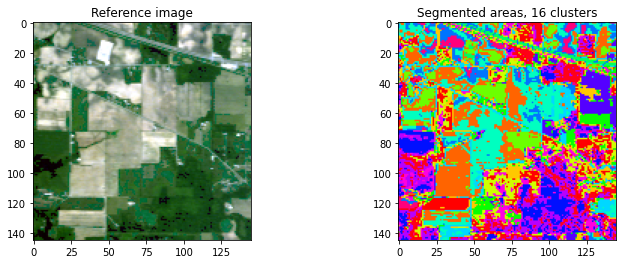

In [372]:
from sklearn.cluster import MiniBatchKMeans

def applyMiniBatchKmeans(image, image_ref, n_clusters, /):
    image = prepareImage(image.copy(), add_coords=True)
    return applySimpleClusterer(image, image_ref, n_clusters, MiniBatchKMeans( n_clusters, random_state=3))
    
label_img = applyMiniBatchKmeans(arr_indiana, arr_indiana_rgb, 16)

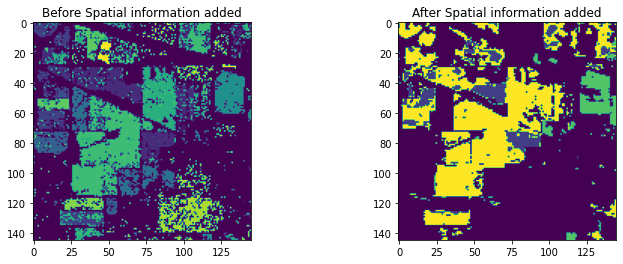

Before  After
precision    0.78   0.81
recall       0.74   0.57
f1-score     0.75   0.66

In [373]:
randomForestWithSpatialInfo(X, y, label_img)

## `KMeans`

n_features: 202


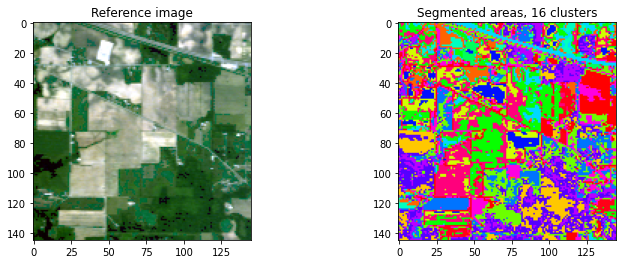

In [266]:
from sklearn.cluster import KMeans

def applyKmeans(image, image_ref, n_clusters, /,):
    image = prepareImage(image.copy(), add_coords=True)
    applySimpleClusterer(image, image_ref, 16, KMeans(16, random_state=3))
    
applyKmeans(arr_indiana, arr_indiana_rgb, 16)

## `SpectralClustering`

In [ ]:
from sklearn.cluster import SpectralClustering

def applySpectralClustering(image, image_ref, n_clusters):
    image = prepareImage(image.copy(), add_coords=True)
    applySimpleClusterer(image, image_ref, 16, SpectralClustering(16, random_state=3))
    
# My 16 gib machine could not handle the memory footprint which makes its usage quite complicated
# applySpectralClustering(indiana, indiana_rgb_pimped, 16)

## `GaussianMixture`

n_features: 202


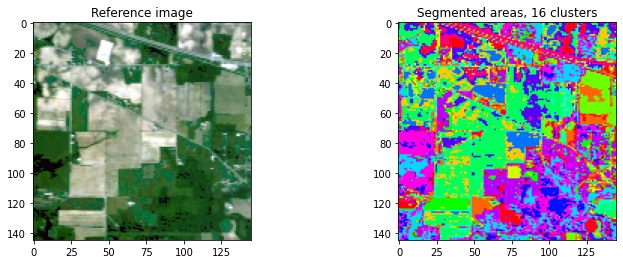

In [377]:
from sklearn.mixture import GaussianMixture

def applyGaussianMixture(image, image_ref, n_clusters):
    image = prepareImage(image.copy(), add_coords=True)
    return applySimpleClusterer(image, image_ref, 16, GaussianMixture(16, random_state=3))
    
label_img = applyGaussianMixture(arr_indiana, arr_indiana_rgb, 16)

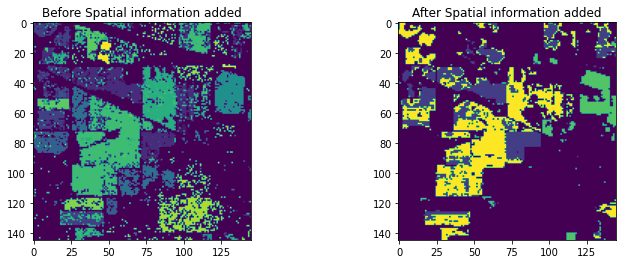

Before  After
precision    0.78   0.79
recall       0.74   0.57
f1-score     0.75   0.67

In [378]:
randomForestWithSpatialInfo(X, y, label_img)

La segmentation non supervisée ne permet pas forcément de segmenter l'image d'entrée de manière efficace. Il faudrait en effet trouver les paramètres optimaux pour chaque image, ce qui n'est pas forcément faisable ici.

## Watershed algorithm
Tarabalka, Y., Chanussot, J., & Benediktsson, J. A. (2010). Segmentation and classification of hyperspectral images using watershed transformation. Pattern Recognition, 43(7), 2367-2379.

L'article cité ci dessus propose de calculer une image de labels de bassins à l'aide du watershed, puis d'utiliser cette image pour obtenir l'information spatiale.

In [374]:
from scipy import ndimage as ndi
from skimage.filters import rank
from skimage.morphology import ball, disk, square
from skimage.filters import sobel, roberts
from skimage.util import img_as_ubyte
from skimage.segmentation import watershed


def generate_watershed_labels(arr, show_images=False, use_markers=True, m_thresh=5):
    grad = np.zeros_like(arr[:,:,0], dtype="int64")

    # first compute the gradient for all of the bands
    # by summing all the gradients
    for i in range(arr.shape[2]):
        band = arr[:,:,i]
        band = img_as_ubyte(band)
        denoised = rank.median(band, square(2))
        gradient = rank.gradient(denoised, square(2))
        grad += gradient
        
    # normalize it 
    grad = normalize(grad) * 255
    
    if (show_images):
        fig, ax = plt.subplots(1, 2, figsize=(10,10))
        ax[0].imshow(grad, cmap="gray")
        ax[0].set_title("Gradient over all bands")
    
    # compute the markers by thresholding the gradient and labelling 
    
    markers = grad < m_thresh
    markers = skimage.morphology.erosion(markers, selem=square(3))
    markers = ndi.label(markers)[0]

    if (show_images):
        ax[1].imshow(markers, cmap="viridis")
        ax[1].set_title("Markers")
        
    # do the watershed algorithm
    if use_markers:
        wshed = watershed(grad, markers)
    else:
        wshed = watershed(grad)
    
    vals = np.linspace(0,1,1000)
    np.random.shuffle(vals)
    cmap = plt.cm.colors.ListedColormap(plt.cm.jet(vals))

    if (show_images):
        plt.show()
        plt.figure(figsize=(10,10))
        plt.imshow(arr[:,:,60], cmap="gray")
        plt.imshow(wshed, cmap=cmap, alpha=0.5)
        plt.title("Watershed labelled image")
        plt.show()
    return wshed

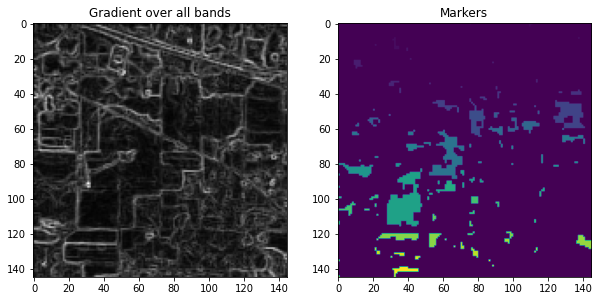

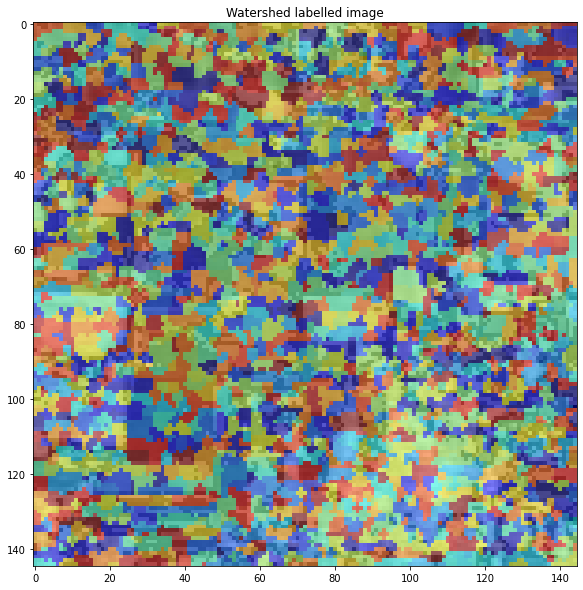

In [375]:
wshed = generate_watershed_labels(X, show_images=True, use_markers=False, m_thresh=25)

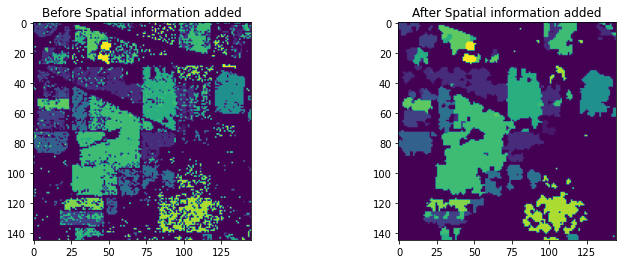

Before  After
precision    0.78   0.83
recall       0.74   0.78
f1-score     0.75   0.79

In [376]:
randomForestWithSpatialInfo(X, y, wshed)

On remarque que cette technique est efficace pour améliorer les résultats. Cependant, il est important de régler les paramètres de la méthode qui calcule les marqueurs pour chaque image. En effet, selon les images la limite à garder est différente.